In [1]:
import lowmapper as lm

import os
import math
import time
from pathlib import Path
import shutil

import geopandas as gpd

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from shapely.geometry import Point
import yaml

start_time = time.time()
print("[INFO] Loading config...")
config_path = "cfg/default.yaml"
config = lm.parse_yaml(config_path)
lm.display_config(config)
print(f"Time elapsed: {time.time() - start_time:.2f}s")

[INFO] Loading config...
config: sonar_path=examples/Sonar_2023-09-12_09.04.57.sl2, save_path=outputs, filename_as_project_name=True, project_name=Sonar, save_csv=True, save_csv_all=True, transducer_x_offset=0,0, transducer_y_offset=0,0, egn=True, egn_stretch=2, egn_stretch_factor_min=10, egn_stretch_factor_max=90, water_column_present=True, water_column_removed=True, sonogram_img_format=png, export_speed_corrected=True, speed_correction=False, remove_shadows=0, depth_detection_method=0, smooth_depth=True, adjust_depth=0, plot_bedpicks=0, resolution=0.2, export_georef_sidescan=gtiff, export_sidescan_substrates_map=True, sidescan_wcp=True, sidescan_wcr=True, colormap=hotdog, map_substrate=False, subtrate_plots=False, substrate_raster=False, substrate_polygon=False, classification_method=max, 
Time elapsed: 0.00s


In [2]:
start_time = time.time()
print("\n[INFO] Reading sonar data...")
sonar = lm.Sonar(config["sonar_path"], config, augment_coords=False)  # todo one cofnig
print(f"Time elapsed: {time.time() - start_time:.2f}s")


[INFO] Reading sonar data...
Time elapsed: 1.02s


In [3]:
if config["filename_as_project_name"]:
    project_name = Path(config["sonar_path"]).stem
else:
    project_name = config["project_name"]
project_folder = os.path.join(config["save_path"], project_name)

if not os.path.exists(project_folder):
    print(f"Project folder not found. Creating project folder ({project_name})...")
    os.makedirs(project_folder)
else:
    print(f"Project folder exists. Removing project folder...")
    shutil.rmtree(project_folder)
    print(f"Creating project folder ({project_name})...")
    os.makedirs(project_folder)

sidescan = lm.SideScan(sonar.sidescan_df(), config)

start_time = time.time()
print("\n[INFO] Creating csv(s)...")
sonar.csvs()
print(f"Time elapsed: {time.time() - start_time:.2f}s")

start_time = time.time()
print("\n[INFO] Creating sonograms...")
sonar.primary_image()
sonar.downscan_image()
sonograms = sidescan.sonograms()

print(f"Time elapsed: {time.time() - start_time:.2f}s")

start_time = time.time()
print("\n[INFO] Creating georeferenced side scans...")
sidescan.georeference(sonograms)
print(f"Time elapsed: {time.time() - start_time:.2f}s")

start_time = time.time()
print("\n[INFO] Creating shapefiles...")
sonar.points_shapefile()
print(f"Time elapsed: {time.time() - start_time:.2f}s")

start_time = time.time()
print("\n[INFO] Creating plots...")
sonar.bathy_map()
print(f"Time elapsed: {time.time() - start_time:.2f}s")

Project folder exists. Removing project folder...
Creating project folder (Sonar_2023-09-12_09.04.57)...

[INFO] Creating csv(s)...
Exporting csv(s)...
Time elapsed: 1.34s

[INFO] Creating sonograms...
Exporting `primary` channel sonogram...
Exporting `downscan` channel sonogram...
Creating water column present...
Creating water column removed...
Slant correcting starboard...


100%|██████████| 5857/5857 [00:08<00:00, 718.41it/s]


Slant correcting port...


100%|██████████| 5857/5857 [00:08<00:00, 715.27it/s]


Applying EGN on sidescan_wcp...
Applying EGN percentile clip stretch on sidescan_wcp...
Applying EGN on sidescan_wcr...
Applying EGN percentile clip stretch on sidescan_wcr...
Exporting `sidescan` channel sonogram(s)...
Time elapsed: 18.55s

[INFO] Creating georeferenced side scans...


100%|██████████| 5857/5857 [00:14<00:00, 410.16it/s]


Exporting georeferenced sidescan(s)...


100%|██████████| 5857/5857 [00:13<00:00, 420.06it/s]


Exporting georeferenced sidescan(s)...
Time elapsed: 36.59s

[INFO] Creating shapefiles...
Exporting points shapefile...
Time elapsed: 4.52s

[INFO] Creating plots...
Exporting bathy map...
Time elapsed: 0.72s


In [4]:
sonograms = sidescan.sonograms()

Creating water column present...
Creating water column removed...
Slant correcting starboard...


100%|██████████| 5857/5857 [00:08<00:00, 712.29it/s]


Slant correcting port...


100%|██████████| 5857/5857 [00:08<00:00, 716.79it/s]


Applying EGN on sidescan_wcp...
Applying EGN percentile clip stretch on sidescan_wcp...
Applying EGN on sidescan_wcr...
Applying EGN percentile clip stretch on sidescan_wcr...
Exporting `sidescan` channel sonogram(s)...


In [5]:
sonograms["sidescan_wcr"]

array([[85, 85, 85, ..., 85, 85, 85],
       [85, 85, 85, ..., 85, 85, 85],
       [85, 85, 85, ..., 85, 85, 85],
       ...,
       [85, 85, 85, ..., 85, 85, 85],
       [85, 85, 85, ..., 85, 85, 85],
       [85, 85, 85, ..., 85, 85, 85]], dtype=uint8)

100%|██████████| 5857/5857 [00:17<00:00, 342.11it/s]


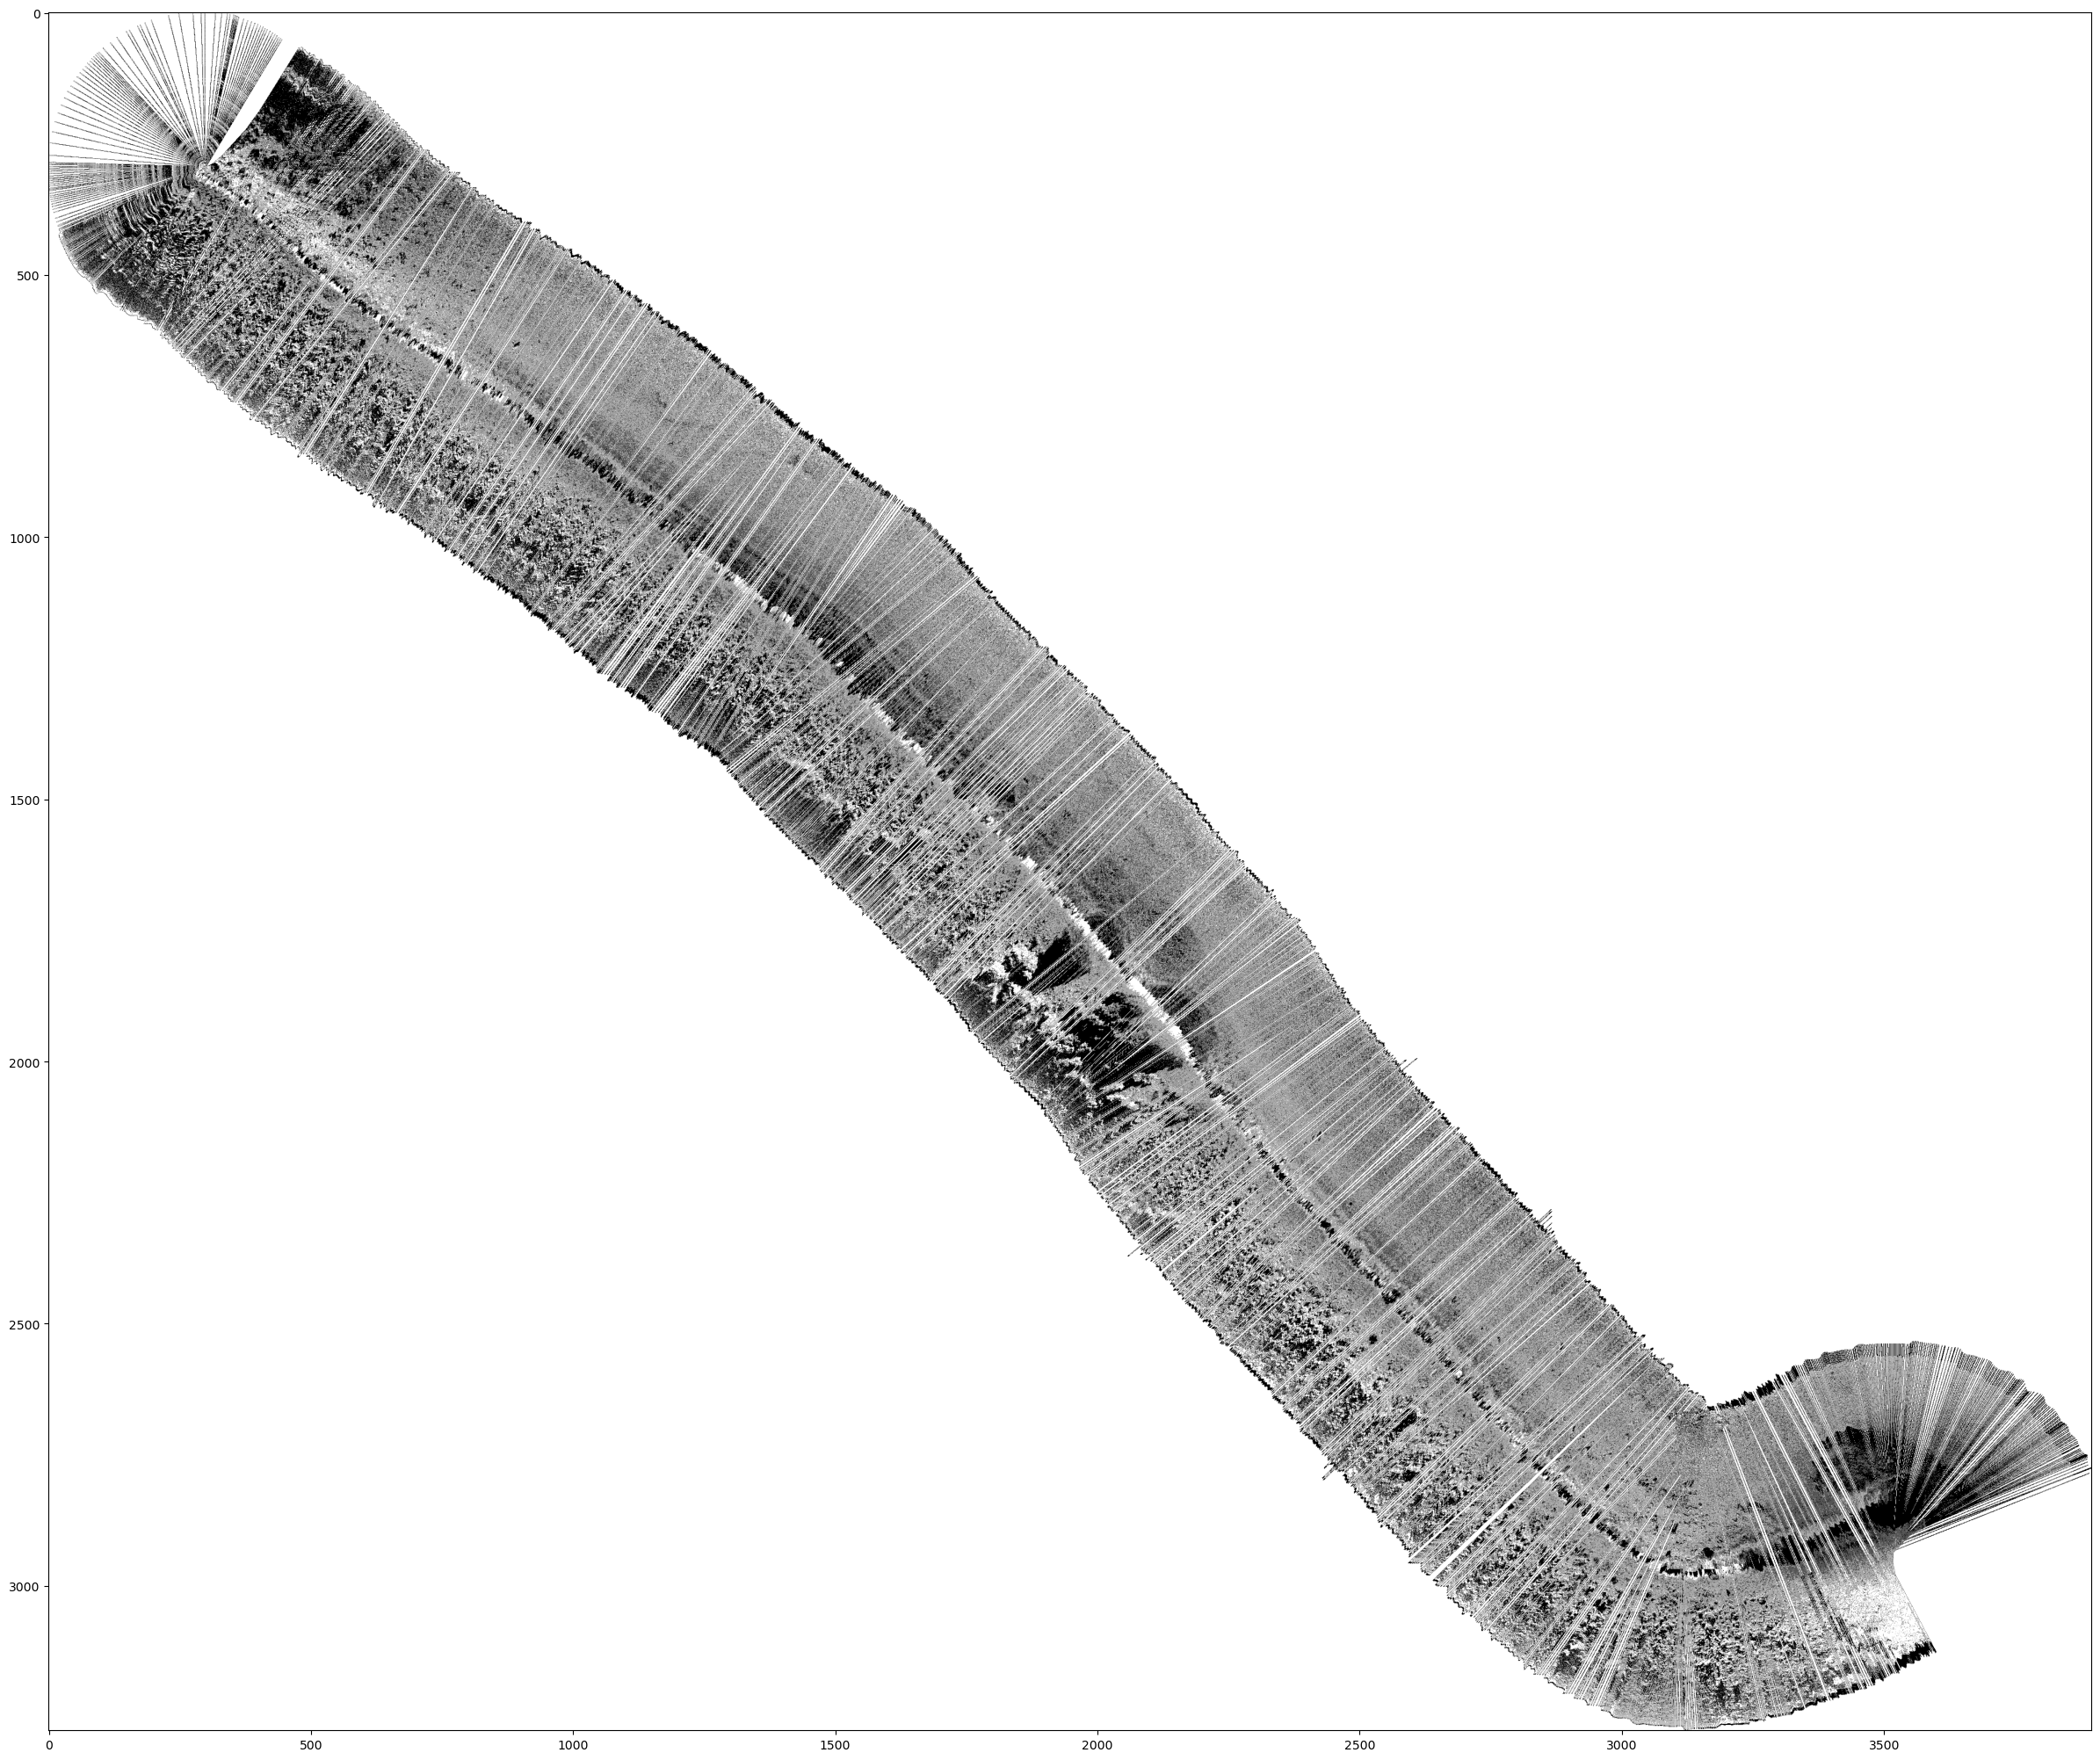

In [6]:
from lowmapper.utils import x_to_longitude, y_to_latitude
from tqdm import tqdm

resolution = 0.2

distances = np.stack(
    [
        np.linspace(start, stop, len(f))
        for start, stop, f in zip(
            sidescan.df["min_range"], sidescan.df["max_range"], sidescan.df["frames"]
        )
    ]
)
# Intensities
sidescan_z = sonograms["sidescan_wcr"]
sidescan_x = np.expand_dims(sidescan.df["x"], axis=1) + distances * np.cos(
    np.expand_dims(sidescan.df["gps_heading"], axis=1)
)
sidescan_y = np.expand_dims(sidescan.df["y"], axis=1) - distances * np.sin(
    np.expand_dims(sidescan.df["gps_heading"], axis=1)
)

# TODO: utils
sidescan_lon = x_to_longitude(sidescan_x)
sidescan_lat = y_to_latitude(sidescan_y)

# Used to adjust values to the correct pixel coordinates
min_x = np.min(sidescan_x)
min_y = np.min(sidescan_y)

# Scale the coordinates to pixel values by resolution (meter per pixel)
# resolution = 1
sidescan_x_scaled = ((sidescan_x - min_x) / resolution).astype(int)
sidescan_y_scaled = ((sidescan_y - min_y) / resolution).astype(int)

# Determine the width and height of the image from scaled by resolution
min_x_scaled = np.min(sidescan_x_scaled)
max_x_scaled = np.max(sidescan_x_scaled)
min_y_scaled = np.min(sidescan_y_scaled)
max_y_scaled = np.max(sidescan_y_scaled)

width = max_x_scaled - min_x_scaled
height = max_y_scaled - min_y_scaled

# Clip coordinates to ensure they are within the bounds of the image
# Because pixel coordinates starts at 0
sidescan_x_scaled = np.clip(sidescan_x_scaled, 0, width - 1)
sidescan_y_scaled = np.clip(sidescan_y_scaled, 0, height - 1)
    
# Blank transparent image
image = np.zeros((height, width, 4), dtype=np.uint8)

# Get pixel distance from center
half_len = len(sidescan_z[0]) // 2
sidescan_d = np.concatenate((np.arange(half_len, 0, -1), np.arange(1, half_len + 1)))

# Assign pixel values
image_coords = {}  # track image coord

for ping in tqdm(range(len(sidescan_z))):
    for y, x, z, d in zip(
        sidescan_y_scaled[ping],
        sidescan_x_scaled[ping],
        sidescan_z[ping],
        sidescan_d,
    ):
        # Check if an image coord has an already assigned value
        # If yes, check which value is closer to the sonar (by distance)
        coord = (y, x)
        if coord not in image_coords or (
            coord in image_coords and d < image_coords[coord]
        ):
            image[y, x, 0] = z
            image[y, x, 1] = z
            image[y, x, 2] = z
            image[y, x, 3] = 255

            image_coords[coord] = d

# since x y coordinate actually starts from bottom left,
# while image application of pixel coordinates starts from top left,
# we fix the orientation by flipping vertically
image = np.flipud(image)

# Determine the bounds of lat long
min_long = np.min(sidescan_lon)
max_long = np.max(sidescan_lon)
min_lat = np.min(sidescan_lat)
max_lat = np.max(sidescan_lat)

plt.figure(figsize=(30, 30))
plt.imshow(image)

  0%|          | 0/3276 [00:00<?, ?it/s]

100%|██████████| 3276/3276 [01:49<00:00, 29.85it/s]


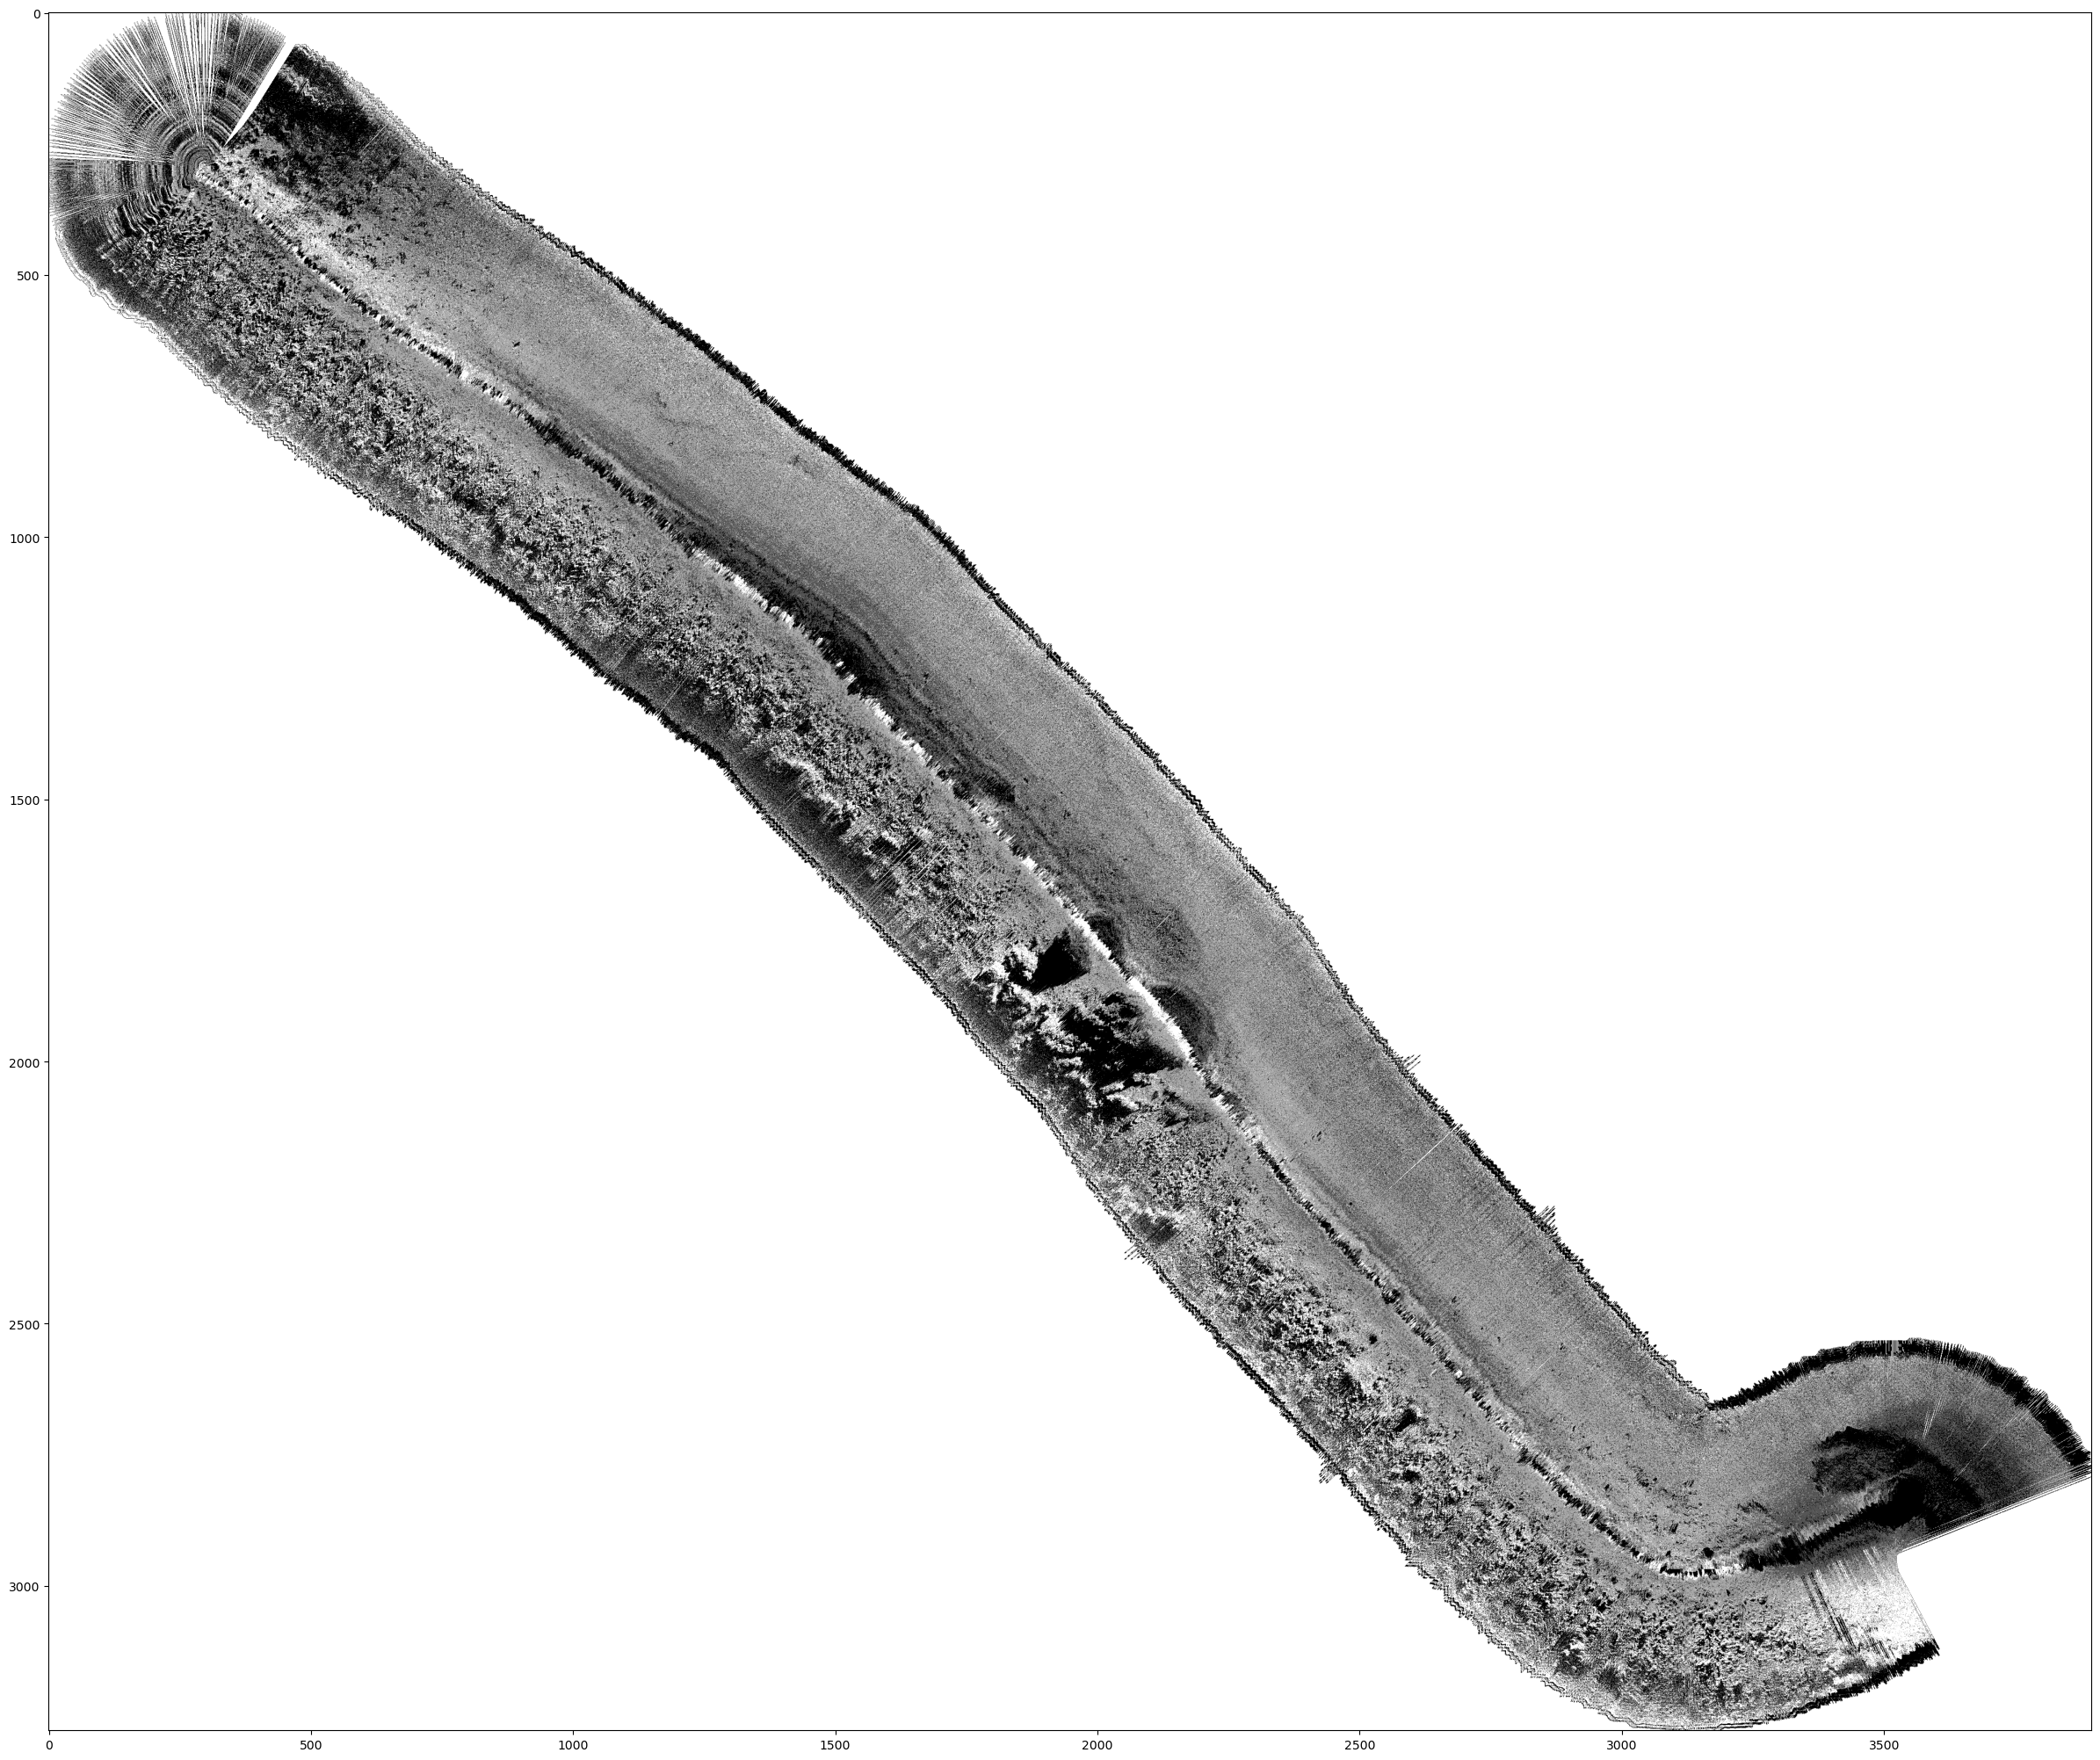

In [7]:
n=6
image_filled = image.copy()

# Get the height and width of the image
height, width = image.shape[:2]

# Iterate over each pixel in the image
for y in tqdm(range(height)):
    for x in range(width):
        if image[y, x, 3] != 0:
            continue
        # Initialize a list to store the RGBA values of the neighboring pixels
        neighbors = []

        # Check the nth place top left, top right, bottom left, and bottom right pixels
        for dy, dx in [(-n, -n), (-n, n), (n, -n), (n, n)]:
            ny, nx = y + dy, x + dx

            # Skip if the neighbor pixel is outside the image boundaries
            if ny < 0 or ny >= height or nx < 0 or nx >= width:
                continue

            # Skip if the neighbor pixel is transparent
            if image[ny, nx, 3] == 0:
                continue

            # Add the neighbor pixel's RGBA values to the list
            neighbors.append(image[ny, nx])

        # Skip if all four neighbors are transparent
        if not neighbors:
            continue

        # Calculate the average RGBA values of the non-transparent neighbors
        avg_color = np.mean(neighbors, axis=0)

        # Assign the average color to the current pixel
        image_filled[y, x] = avg_color


plt.figure(figsize=(30, 30))
plt.imshow(image_filled)

In [8]:
!=

SyntaxError: invalid syntax (2702273413.py, line 1)

In [ ]:
import numpy as np
from scipy.ndimage import generic_filter
from tqdm import tqdm

def nearest_neighbor_interpolation_mask(image):
    # Create a mask for transparent pixels
    mask = (image[..., 3] == 0)
    
    # Apply nearest neighbor interpolation only to transparent pixels
    def interpolate_pixel(pixel):
        
        non_transparent = pixel[pixel[..., 3] != 0]
        if len(non_transparent) > 0:
            return non_transparent[0]  # Nearest non-transparent pixel
        return pixel
    
    # Apply interpolation using a 3x3 window
    h, w, _ = image.shape
    interpolated_image = np.zeros_like(image)
    for y in tqdm(range(h)):
        for x in range(w):
            interpolated_image[y, x] = interpolate_pixel(image[y:y+3, x:x+3])
    
    # Restore transparency using the mask
    interpolated_image[mask] = [0, 0, 0, 0]
    
    return interpolated_image

# Apply nearest neighbor interpolation with masking and progress bar
nearest_image_mask = nearest_neighbor_interpolation_mask(image)

print(nearest_image_mask.shape)  # Output will be the same as the input image shape


In [ ]:
from scipy import ndimage

# Define a mask where the image is blank (all channels are 0)
mask = np.all(image[:, :, :3] == 0, axis=2)

# Get the coordinates of the non-zero pixels
coords = np.array(np.nonzero(~mask))

# Get the values of the non-zero pixels
values = image[~mask]

# Create an array of indices for the entire image
grid_y, grid_x = np.mgrid[0:image.shape[0], 0:image.shape[1]]

# Apply bilinear interpolation
image_interp = np.zeros_like(image)
for i in range(3):  # for each color channel
    image_interp[:, :, i] = ndimage.griddata(coords.T, image[~mask, i], (grid_y, grid_x), method='linear', fill_value=0)

In [ ]:
plt.figure(figsize=(30, 30))
plt.imshow(interpolated_image)

In [ ]:
from rasterio.transform import from_bounds
import rasterio

image_np = image

image = Image.fromarray(image_np, "RGBA")
width, height = image.size

# Save the image as PNG with transparency
image.save("geo.png", "PNG")

# GEOTIF
transform = from_bounds(min_long, min_lat, max_long, max_lat, width, height)

with rasterio.open(
    "geo.tif",
    "w",
    driver="GTiff",
    height=image_np.shape[0],
    width=image_np.shape[1],
    count=4,
    dtype=image_np.dtype,
    crs="EPSG:4326",
    transform=transform,
) as dst:
    dst.write(image_np.transpose(2, 0, 1))


In [ ]:
image

In [ ]:
!=

In [ ]:
# SHORT SLANT CORRECTION
start_time = time.time()

ports = sidescan._port()
ports = np.fliplr(ports)

depths = sidescan.df["water_depth"]
absolute_range = sidescan.df["max_range"].iloc[0]

corrected_ports = np.zeros_like(ports)

slant_ranges = np.linspace(0, absolute_range, len(ports[0]))

for i in range(ports.shape[0]):
    depth = depths[i]
    port = ports[i]

    slant_corrected = np.full(len(port), np.nan, dtype=np.float32)

    horizontal_distances = np.sqrt(slant_ranges**2 - depth**2)
    horizontal_distances *= len(port) / absolute_range

    # Perform slant range correction
    for j, distance in enumerate(horizontal_distances):
        if 0 <= distance < len(port):
            slant_corrected[int(distance)] = port[j]
            # corrected_ports[i, int(distance)] = port[j]

    corrected_ports[i] = slant_corrected

corrected_ports = np.fliplr(corrected_ports)
plt.figure(figsize=(20, 20))
plt.imshow(corrected_ports, cmap="gray")

end_time = time.time()
print(f"Time elapsed: {end_time - start_time:.2f}s")
corrected_ports

In [ ]:
from tqdm import tqdm

start_time = time.time()

depths = sidescan.df["water_depth"]
absolute_range = sidescan.df["max_range"].iloc[0]
port = sidescan._port()
port = np.fliplr(port)

all_slant_corrected = np.zeros((port.shape[0], port.shape[1])).astype(np.float32)
# horizontal_dist = np.sqrt(absolute_range**2 - depths**2).astype(int)

for i in tqdm(range(port.shape[0])):
    depth = ((depths[i] * port.shape[1]) / absolute_range).astype(int)
    slant_corrected = np.full(port.shape[1], np.nan, dtype=np.float32)
    dataExtent = 0

    # Iterate each sonar/ping return
    for j in range(port.shape[1]):
        if j >= depth:
            intensity = port[i, j]
            horizontal_dist = int(round(math.sqrt(j**2 - depth**2), 0))
            slant_corrected[horizontal_dist] = intensity
            dataExtent = horizontal_dist

    slant_corrected[dataExtent:] = 0

    # Replace NaN values with interpolation
    valid = ~np.isnan(slant_corrected)
    slant_corrected[~valid] = np.interp(
        np.flatnonzero(~valid), np.flatnonzero(valid), slant_corrected[valid]
    )

    all_slant_corrected[i] = slant_corrected

port_wcr = np.fliplr(all_slant_corrected)
port_wcr = port_wcr.astype(np.uint8)

port_wcr[port_wcr == 0] = 1

plt.figure(figsize=(20, 20))
plt.imshow(port_wcr, cmap="gray")

end_time = time.time()
print(f"Time elapsed: {end_time - start_time:.2f}s")

In [ ]:
port_wcr

In [ ]:
port_wcr

In [ ]:
port_wcr[0]

In [ ]:
port[0]

In [ ]:
!=

In [ ]:
from lowmapper.utils import x_to_longitude, y_to_latitude
from tqdm import tqdm

resolution = 0.2

sidescan_df = sidescan.df


# Determine the coordinates of each pixel
distances = np.stack(
    [
        np.linspace(start, stop, len(f))
        for start, stop, f in zip(
            sidescan.df["min_range"], sidescan.df["max_range"], sidescan.df["frames"]
        )
    ]
)
# Intensities
sidescan_z = sidescan.image
sidescan_x = np.expand_dims(sidescan.df["x"], axis=1) + distances * np.cos(
    np.expand_dims(sidescan.df["gps_heading"], axis=1)
)
sidescan_y = np.expand_dims(sidescan.df["y"], axis=1) - distances * np.sin(
    np.expand_dims(sidescan.df["gps_heading"], axis=1)
)

sidescan_long = x_to_longitude(sidescan_x)
sidescan_lat = y_to_latitude(sidescan_y)

# Used to adjust values to the correct pixel coordinates
min_x = np.min(sidescan_x)
min_y = np.min(sidescan_y)

# Scale the coordinates to pixel values by resolution (meter per pixel)
# resolution = 1
sidescan_x_scaled = ((sidescan_x - min_x) / resolution).astype(int)
sidescan_y_scaled = ((sidescan_y - min_y) / resolution).astype(int)

# Determine the width and height of the image from scaled by resolution
min_x_scaled = np.min(sidescan_x_scaled)
max_x_scaled = np.max(sidescan_x_scaled)
min_y_scaled = np.min(sidescan_y_scaled)
max_y_scaled = np.max(sidescan_y_scaled)

width = max_x_scaled - min_x_scaled
height = max_y_scaled - min_y_scaled

# Clip coordinates to ensure they are within the bounds of the image
# Because pixel coordinates starts at 0
sidescan_x_scaled = np.clip(sidescan_x_scaled, 0, width - 1)
sidescan_y_scaled = np.clip(sidescan_y_scaled, 0, height - 1)

# Blank transparent image
image = np.zeros((height, width, 4), dtype=np.uint8)

# Assign pixel values
# image[sidescan_y_scaled, sidescan_x_scaled, 0] = sidescan_z
# image[sidescan_y_scaled, sidescan_x_scaled, 1] = sidescan_z
# image[sidescan_y_scaled, sidescan_x_scaled, 2] = sidescan_z
# image[sidescan_y_scaled, sidescan_x_scaled, 3] = 255

# Get pixel distance from center
half_len = len(sidescan_z[0]) // 2
decreasing = np.arange(half_len, 0, -1)
increasing = np.arange(1, half_len + 1)
sidescan_d = np.concatenate((decreasing, increasing))

In [ ]:
# Assign pixel values
image_coords = {}  # track image coord

for ping in tqdm(range(len(sidescan_z))):
    for y, x, z, d in zip(
        sidescan_y_scaled[ping],
        sidescan_x_scaled[ping],
        sidescan_z[ping],
        sidescan_d,
    ):
        # Check if an image coord has an already assigned value
        # If yes, check which value is closer to the sonar (by distance)
        coord = (y, x)
        if coord not in image_coords or (
            coord in image_coords and d < image_coords[coord]
        ):
            image[y, x, 0] = z
            image[y, x, 1] = z
            image[y, x, 2] = z
            image[y, x, 3] = 255

            image_coords[coord] = d

# since x y coordinate actually starts from bottom left,
# while image application of pixel coordinates starts from top left,
# we fix the orientation by flipping vertically
image = np.flipud(image)

# Determine the bounds of lat long
min_long = np.min(sidescan_long)
max_long = np.max(sidescan_long)
min_lat = np.min(sidescan_lat)
max_lat = np.max(sidescan_lat)


# plt im show change size bigger than normal
plt.figure(figsize=(10, 10))
plt.imshow(image)

In [ ]:
!=

In [ ]:
from lowmapper.utils import x_to_longitude, y_to_latitude

resolution = 1

sidescan_df = sidescan.df

distances = np.stack(
    [
        np.linspace(start, stop, len(f))
        for start, stop, f in zip(
            sidescan_df["min_range"], sidescan_df["max_range"], sidescan_df["frames"]
        )
    ]
)
sidescan_z = sidescan.image  # image is the intensities
sidescan_x = np.expand_dims(sidescan_df["x"], axis=1) + distances * np.cos(
    np.expand_dims(sidescan_df["gps_heading"], axis=1)
)
sidescan_y = np.expand_dims(sidescan_df["y"], axis=1) - distances * np.sin(
    np.expand_dims(sidescan_df["gps_heading"], axis=1)
)

In [ ]:
half_len = len(sidescan_z[0]) // 2

# Create two arrays: one decreasing from half_len to 1, and one increasing from 1 to half_len
decreasing = np.arange(half_len, 0, -1)
increasing = np.arange(1, half_len + 1)

# Concatenate the two arrays to get sidescan_d
sidescan_d = np.concatenate((decreasing, increasing))

In [ ]:
sidescan_long = x_to_longitude(sidescan_x)
sidescan_lat = y_to_latitude(sidescan_y)

# Used to adjust values to the correct pixel coordinates
min_x = np.min(sidescan_x)
min_y = np.min(sidescan_y)

# Scale the coordinates to pixel values by resolution (meter per pixel)
# resolution = 1
sidescan_x_scaled = ((sidescan_x - min_x) / resolution).astype(int)
sidescan_y_scaled = ((sidescan_y - min_y) / resolution).astype(int)

# Determine the width and height of the image from scaled by resolution
min_x_scaled = np.min(sidescan_x_scaled)
max_x_scaled = np.max(sidescan_x_scaled)
min_y_scaled = np.min(sidescan_y_scaled)
max_y_scaled = np.max(sidescan_y_scaled)

width = max_x_scaled - min_x_scaled
height = max_y_scaled - min_y_scaled

# Clip coordinates to ensure they are within the bounds of the image
# Because pixel coordinates starts at 0
sidescan_x_scaled = np.clip(sidescan_x_scaled, 0, width - 1)
sidescan_y_scaled = np.clip(sidescan_y_scaled, 0, height - 1)

# Blank transparent image
image = np.zeros((height, width, 4), dtype=np.uint8)

# Assign pixel values
# image[sidescan_y_scaled, sidescan_x_scaled, 0] = sidescan_z
# image[sidescan_y_scaled, sidescan_x_scaled, 1] = sidescan_z
# image[sidescan_y_scaled, sidescan_x_scaled, 2] = sidescan_z
# image[sidescan_y_scaled, sidescan_x_scaled, 3] = 255

# Assign pixel values
image_coords = set()  # track image coord

for ping in range(len(sidescan_z)):
    for y, x, z in zip(
        sidescan_y_scaled[ping], sidescan_x_scaled[ping], sidescan_z[ping]
    ):
        coord = (y, x)
        if coord not in image_coords:
            image[y, x, 0] = z
            image[y, x, 1] = z
            image[y, x, 2] = z
            image[y, x, 3] = 255

            image_coords.add(coord)

In [ ]:
sidescan = lm.SideScan(sonar.sidescan_df(), config)
sidescan_df = sidescan.df
sidescan_df2 = sidescan_df.copy()

port = sidescan._port()
starboard = sidescan._starboard()
absolute_range = sidescan_df2["max_range"].iloc[0]
# plt.figure(figsize=(30, 20))
plt.imshow(port, cmap="gray")

In [ ]:
depths = sidescan.df["water_depth"]
depths

In [ ]:
port = np.fliplr(port)

In [ ]:
# Initialize 2d array to store relocated sonar records
whole_slant_corrected = np.zeros((port.shape[0], port.shape[1])).astype(np.float32)

# Iterate each ping
for i in range(port.shape[0]):
    depth = ((depths[i] * port.shape[1]) / absolute_range).astype(int)

    # Create 1d array to store relocated bed pixels.  Set to nan so we
    ## can later interpolate over gaps.
    slant_corrected = np.full(port.shape[1], np.nan, dtype=np.float32)
    # dataExtent = 0

    # Iterate each sonar/ping return
    for j in range(port.shape[1]):
        if j >= depth:
            # Calculate horizontal range (in pixels) using pathagorean theorem
            horizontal_dist = int(round(math.sqrt(j**2 - depth**2), 0))

            # Store intensity at appropriate horizontal range
            slant_corrected[horizontal_dist] = port[i, j]

    # Zero out values past range extent so we don't interpolate past this
    slant_corrected[horizontal_dist + 1 :] = 0

    # Process of relocating bed pixels will introduce across track gaps
    ## in the array so we will interpolate over gaps to fill them.
    valid = ~np.isnan(slant_corrected)
    slant_corrected[~valid] = np.interp(
        np.flatnonzero(~valid), np.flatnonzero(valid), slant_corrected[valid]
    )

    # Store relocated ping in output array
    whole_slant_corrected[i] = slant_corrected

whole_slant_corrected = np.fliplr(whole_slant_corrected)

plt.figure(figsize=(30, 20))
plt.imshow(whole_slant_corrected, cmap="gray")

In [ ]:
# Initialize 2d array to store relocated sonar records
all_slant_corrected = np.zeros((starboard.shape[0], starboard.shape[1])).astype(
    np.float32
)
horizontal_dist = np.sqrt(absolute_range**2 - depths**2).astype(int)

# Iterate each ping
for i in range(starboard.shape[0]):
    depth = ((depths[i] * starboard.shape[1]) / absolute_range).astype(int)
    dd = depth**2

    # Create 1d array to store relocated bed pixels.  Set to nan so we
    ## can later interpolate over gaps.
    slant_corrected = np.full(starboard.shape[1], np.nan, dtype=np.float32)
    dataExtent = 0

    # Iterate each sonar/ping return
    for j in range(starboard.shape[1]):
        if j >= depth:
            # Get the intensity value
            intensity = starboard[i, j]
            # Calculate horizontal range (in pixels) using pathagorean theorem
            horizontal_dist = int(round(math.sqrt(j**2 - dd), 0))
            # Store intensity at appropriate horizontal range
            slant_corrected[horizontal_dist] = intensity
            # Store range extent (max range) of ping
            dataExtent = horizontal_dist
    # Zero out values past range extent so we don't interpolate past this
    slant_corrected[dataExtent:] = 0

    # Process of relocating bed pixels will introduce across track gaps
    ## in the array so we will interpolate over gaps to fill them.
    valid = ~np.isnan(slant_corrected)
    slant_corrected[~valid] = np.interp(
        np.flatnonzero(~valid), np.flatnonzero(valid), slant_corrected[valid]
    )

    # Store relocated ping in output array
    all_slant_corrected[i] = slant_corrected

plt.figure(figsize=(30, 20))
plt.imshow(all_slant_corrected, cmap="gray")

In [ ]:
mean_per_column = np.mean(all_slant_corrected.astype(np.uint8), axis=0)
normalized_by_mean_image = all_slant_corrected / mean_per_column

print("Number of NaN values:", np.isnan(all_slant_corrected).sum())
print("Number of zero values:", (all_slant_corrected == 0).sum())

In [ ]:
port

In [ ]:
all_slant_corrected.astype(np.int32)

In [ ]:
absolute_range = sidescan.df["max_range"].iloc[0]

n_pings = starboard.shape[0]  # number of pings in a session
n_frame = starboard.shape[1]  # number of pixel in a frame

depths = sidescan.df["water_depth"]

# Horizontal distance of max range
horizontal_dist = np.sqrt(absolute_range**2 - depths**2).astype(int)

# Get equally spaced distances of horizontal
starboard_horizontal_dists = np.linspace(
    depths, horizontal_dist, n_frame, axis=1
).astype(int)

# Convert to horizontal distances to pixel value
starboard_horizontal_dists = (
    (starboard_horizontal_dists * n_frame) / absolute_range
).astype(int)

starboard_wcr = np.zeros((n_pings, n_frame))

for n in range(n_pings):
    # starboard_frame = np.zeros((n_frame))
    starboard_frame = np.full(starboard.shape[1], np.nan, dtype=np.float32)

    horizontals = []
    for m in range(n_frame):
        pixel_location = starboard_horizontal_dists[n][m]

        if pixel_location in horizontals:
            continue
        starboard_frame[m] = starboard[n][pixel_location]
        horizontals.append(starboard_horizontal_dists[n][m])

    valid = ~np.isnan(starboard_frame)
    starboard_frame[~valid] = np.interp(
        np.flatnonzero(~valid), np.flatnonzero(valid), starboard_frame[valid]
    )

    # print(starboard_frame)
    starboard_wcr[n] = starboard_frame

plt.figure(figsize=(30, 20))
plt.imshow(starboard_wcr, cmap="gray")

In [ ]:
mean_per_column = np.mean(starboard_wcr, axis=0)
normalized_by_mean_image = starboard_wcr / mean_per_column

In [ ]:
starboard_wcr

In [ ]:
plt.figure(figsize=(30, 20))
plt.imshow(starboard, cmap="gray")

In [ ]:
sidescan_df = sidescan.df
sidescan_df2 = sidescan_df.copy()

plt.imshow(np.stack(sidescan_df2["frames"]), cmap="gray")

In [ ]:
# Calculate the time elapsed between consecutive pings
sidescan_df2["time_elapsed"] = (
    sidescan_df2["datetime"] - sidescan_df2["datetime"].shift()
).fillna(pd.Timedelta(seconds=0))

# Convert the time elapsed to seconds
sidescan_df2["time_elapsed"] = sidescan_df2["time_elapsed"].dt.total_seconds()

# Calculate the cumulative sum of the time elapsed
sidescan_df2["cum_time_elapsed"] = sidescan_df2["time_elapsed"].cumsum()

# Calculate distance traveled between consecutive rows
sidescan_df2["dist_traveled"] = (
    sidescan_df2["gps_speed"] * sidescan_df2["cum_time_elapsed"].diff()
)

# Fill NaN values in the first row with 0
sidescan_df2["dist_traveled"] = sidescan_df2["dist_traveled"].fillna(0)

# Calculate cumulative distance traveled
sidescan_df2["cum_dist_traveled"] = sidescan_df2["dist_traveled"].cumsum()

In [ ]:
!=

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming sidescan_df is your DataFrame containing 'cum_dist_traveled' and 'frames'

# Extract cumulative distance traveled and frames
cum_dist_traveled = sidescan_df2["cum_dist_traveled"].values
frames = np.stack(sidescan_df2["frames"])

# Define new evenly spaced distances
new_distances = np.linspace(
    cum_dist_traveled.min(), cum_dist_traveled.max(), frames.shape[0]
)

# Interpolate along the row indices
indices = np.arange(frames.shape[0])
interpolated_indices = np.interp(new_distances, cum_dist_traveled, indices)

# Round and cast to integers to use as indices
interpolated_indices = np.round(interpolated_indices).astype(int)

# Interpolate the frames based on the interpolated indices
interpolated_frames = frames[interpolated_indices]

# Visualize the corrected sidescan frames
plt.imshow(interpolated_frames, cmap="gray")
plt.xlabel("Distance")
plt.ylabel("Ping")
plt.title("Speed Corrected Sidescan Frames")
plt.colorbar(label="Intensity")
plt.show()

In [ ]:
# check duplicate values in interpolated_indices
unique, counts = np.unique(interpolated_indices, return_counts=True)
duplicates = unique[counts > 1]
len(duplicates)

In [ ]:
len(indices)

In [ ]:
plt.plot(indices, "-")
plt.plot(interpolated_indices, "x")

In [ ]:
plt.imsave("speedcor.png", interpolated_frames)

In [ ]:
ssimage = np.stack(sonar.sidescan_df()["frames"])

In [ ]:
import numpy as np

# Assuming sidescan_df is your DataFrame containing 'cum_dist_traveled' column

# Calculate the distance between consecutive pings
ping_distances = np.diff(sidescan_df2["cum_dist_traveled"])

# Set a distance threshold for retaining pings (adjust as needed)
distance_threshold = 0.17910178820185996  # Adjust as needed based on your data

# Find the indices of pings to keep (those with distances above the threshold)
indices_to_keep = np.where(ping_distances > distance_threshold)[0]

# Keep only the rows corresponding to the selected indices
sidescan_df_filtered = sidescan_df.iloc[indices_to_keep]

# Now sidescan_df_filtered contains only the rows with pings spaced apart by at least the threshold distance
plt.imshow(np.stack(sidescan_df_filtered["frames"]), cmap="gray")

In [ ]:
import numpy as np

# Assuming 'gps_speed' is the column containing GPS speed in meters per second
gps_speed_per_row = sidescan_df2["gps_speed"].values

# Calculate average GPS speed per row
average_gps_speed = np.mean(gps_speed_per_row)

# Assuming the ping rate is constant, compute the average distance traveled per ping
ping_rate = 1  # Assume one ping per second (adjust as needed)
average_distance_per_ping = average_gps_speed * ping_rate

print("Average distance traveled per ping:", average_distance_per_ping, "meters")

In [ ]:
# calculate average distance traveled between ping
(np.mean(sidescan_df2["dist_traveled"].values))